In [84]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_1d_slice, plot_timeseries, plot_spacetime
from superfv.initial_conditions import square

In [85]:
N = 64
T = 1.0

configs = {
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        PAD={"rho": (0, None), "P": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        blend=False,
        limiting_vars="actives",
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
    ),
}

sims = {}
for name, config in configs.items():
    print(f"Running {name}...")
    sim = EulerSolver(
        ic=partial(square, bounds=(1e-3, 1), P=1e-3, vx=1), nx=N, **config
    )

    try:
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            allow_overshoot=True,
            snapshot_mode="every",
        )
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Running MUSCL-Hancock...
Step #175 @ t=1.00e+00 | dt=5.73e-03 | min(rho)=1.00e-03, min(P)=1.00e-03 | (done)                  
Running ZS3...
Step #187 @ t=1.00e+00 | dt=5.30e-03 | min(rho)=7.28e-04, min(P)=1.00e-03 | (done)                  
Running MM3...
Step #186 @ t=1.00e+00 | dt=5.18e-03 | min(rho)=7.02e-04, min(P)=1.00e-03 | (done)                  


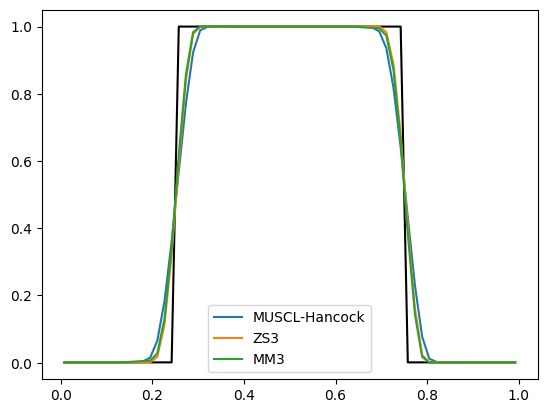

In [86]:
fig, ax = plt.subplots()

plot_1d_slice(sims[list(sims.keys())[0]], ax, "rho", cell_averaged=True, t=0, color="k")
for name, sim in sims.items():
    plot_1d_slice(sim, ax, "rho", cell_averaged=True, label=name)

ax.legend()

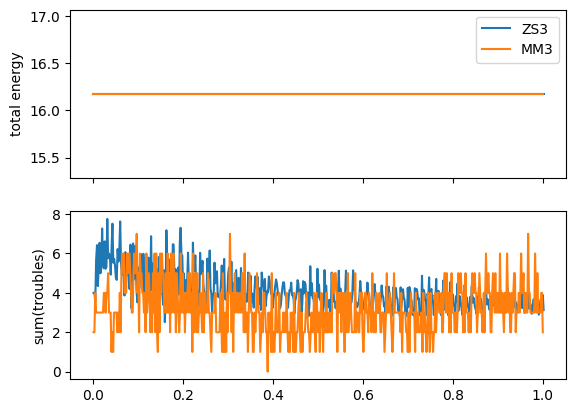

In [87]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].set_ylabel("total energy")
axs[1].set_ylabel("sum(troubles)")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]

plot_timeseries(sim1, axs[0], "total_E", label="ZS3")
plot_timeseries(sim2, axs[0], "total_E", label="MM3")

plot_timeseries(sim1, axs[1], "nfine_1-theta_vis_max", label="ZS3")
plot_timeseries(sim2, axs[1], "nfine_troubles_vis_max", label="MM3")

axs[0].legend()

(<matplotlib.image.AxesImage at 0x11bef09b0>,
 <matplotlib.colorbar.Colorbar at 0x11bf13800>)

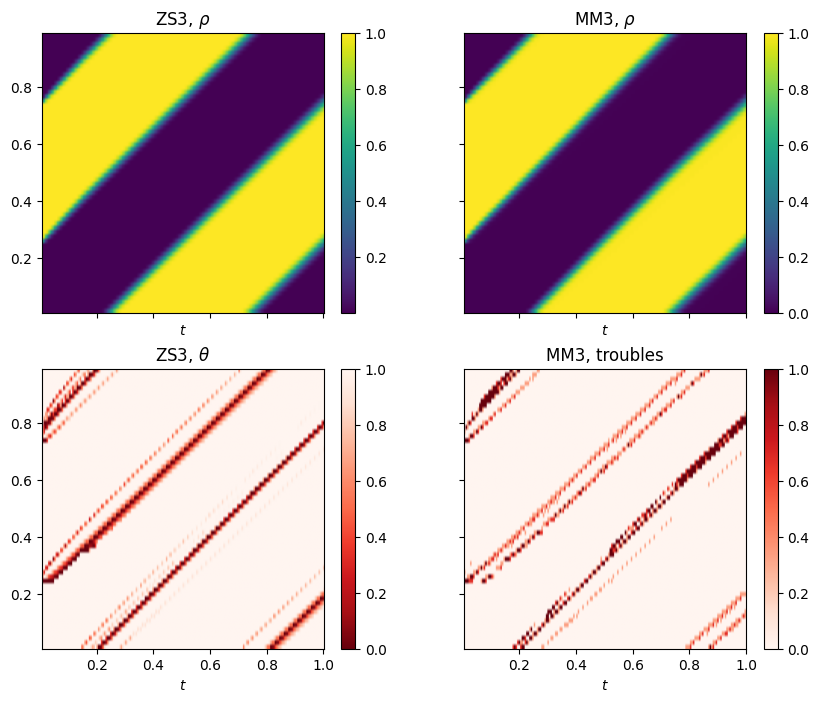

In [88]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axs[0, 0].set_title(r"ZS3, $\rho$")
axs[0, 1].set_title(r"MM3, $\rho$")
axs[1, 0].set_title(r"ZS3, $\theta$")
axs[1, 1].set_title("MM3, troubles")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]

plot_spacetime(sim1, axs[0, 0], "rho", cell_averaged=True, colorbar=True)
plot_spacetime(sim2, axs[0, 1], "rho", cell_averaged=True, colorbar=True)

plot_spacetime(sim1, axs[1, 0], "min", theta=True, colorbar=True, cmap="Reds_r")
plot_spacetime(sim2, axs[1, 1], "max", troubles=True, colorbar=True, cmap="Reds")